CELL 1 — IMPORT LIBRARY

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix

CELL 2 — PATH DATASET

In [2]:
BASE_DIR = "../processed_dataset"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = len(os.listdir(TRAIN_DIR))

print("Jumlah kelas:", NUM_CLASSES)
print("Nama kelas:", os.listdir(TRAIN_DIR))

Jumlah kelas: 12
Nama kelas: ['abyssinian', 'bengal', 'birman', 'bombay', 'british_shorthair', 'egyptian_mau', 'maine_coon', 'persian', 'ragdoll', 'russian_blue', 'siamese', 'sphynx']


CELL 3 — DATA GENERATOR

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 6632 images belonging to 12 classes.
Found 353 images belonging to 12 classes.
Found 360 images belonging to 12 classes.


CELL 4 — ARSITEKTUR CNN SCRATCH (NON-PRETRAINED)

In [4]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)      

CELL 5 — CALLBACK

In [7]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(
        "../models/cnn_scratch_cat_breed.keras",
        monitor="val_accuracy",
        save_best_only=True
    )
]

CELL 6 — TRAINING MODEL

In [8]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
208/208 [==============================] - 221s 1s/step - loss: 2.1987 - accuracy: 0.2343 - val_loss: 1.9915 - val_accuracy: 0.3371
Epoch 2/30
208/208 [==============================] - 209s 1s/step - loss: 1.9002 - accuracy: 0.3457 - val_loss: 1.7832 - val_accuracy: 0.3853
Epoch 3/30
208/208 [==============================] - 210s 1s/step - loss: 1.7382 - accuracy: 0.4058 - val_loss: 1.7251 - val_accuracy: 0.3909
Epoch 4/30
208/208 [==============================] - 205s 986ms/step - loss: 1.5498 - accuracy: 0.4682 - val_loss: 1.6495 - val_accuracy: 0.4278
Epoch 5/30
208/208 [==============================] - 206s 989ms/step - loss: 1.3866 - accuracy: 0.5356 - val_loss: 1.6243 - val_accuracy: 0.4476
Epoch 6/30
208/208 [==============================] - 210s 1s/step - loss: 1.2258 - accuracy: 0.5866 - val_loss: 1.5417 - val_accuracy: 0.4703
Epoch 7/30
208/208 [==============================] - 217s 1s/step - loss: 1.0648 - accuracy: 0.6478 - val_loss: 1.5938 - val_accuracy: 

CELL 7 — GRAFIK LOSS & ACCURACY

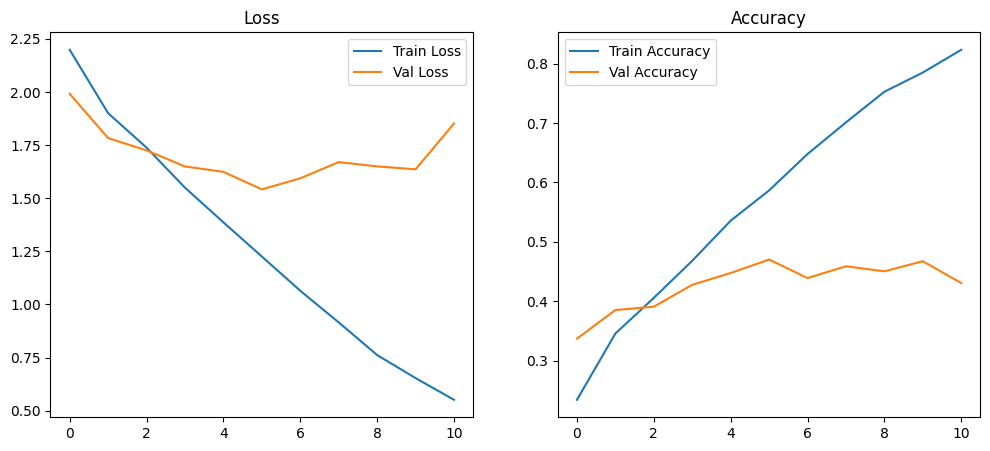

In [9]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy")
plt.legend()

plt.show()

CELL 8 — EVALUASI TEST SET

In [10]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)

12/12 [==============================] - 6s 547ms/step - loss: 1.7022 - accuracy: 0.4194
Test Accuracy: 0.4194444417953491


CELL 9 — CLASSIFICATION REPORT

In [11]:
y_true = test_gen.classes
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

class_labels = list(test_gen.class_indices.keys())

print(classification_report(
    y_true,
    y_pred,
    target_names=class_labels
))

12/12 [==============================] - 3s 264ms/step
                   precision    recall  f1-score   support

       abyssinian       0.53      0.32      0.40        31
           bengal       0.51      0.67      0.58        30
           birman       0.34      0.40      0.37        30
           bombay       0.65      0.83      0.73        29
british_shorthair       0.38      0.33      0.36        30
     egyptian_mau       0.38      0.41      0.39        29
       maine_coon       0.21      0.23      0.22        30
          persian       0.37      0.37      0.37        30
          ragdoll       0.37      0.63      0.46        30
     russian_blue       0.38      0.33      0.36        30
          siamese       0.50      0.29      0.37        31
           sphynx       0.54      0.23      0.33        30

         accuracy                           0.42       360
        macro avg       0.43      0.42      0.41       360
     weighted avg       0.43      0.42      0.41       360

CELL 10 — CONFUSION MATRIX

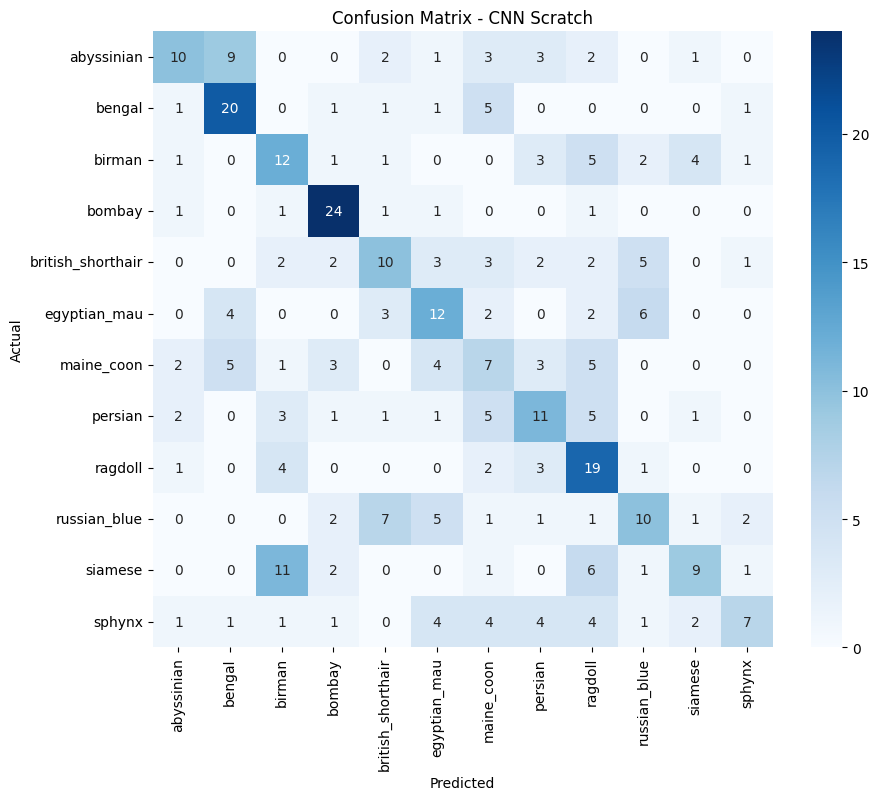

In [12]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    xticklabels=class_labels,
    yticklabels=class_labels,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CNN Scratch")
plt.show()

CELL 11 — SIMPAN MODEL MANUAL (BACKUP)

In [13]:
model.save("../models/cnn_scratch_cat_breed_final.keras")
print("✅ Model CNN Scratch berhasil disimpan")

✅ Model CNN Scratch berhasil disimpan
